In [2]:
1/1280*2**11

1.6

# Install packages and mount google drive

In [ ]:
# prompt: install libraries such as numpy

!pip install numpy
!pip install PyOpenGL glfw
!pip install pyrr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#import glfw
from OpenGL.GL import *
import numpy as np
#import pyrr
import matplotlib.pyplot as plt

# Vertex shading

## Webber's first edition

In [ ]:
# Function to load .obj file
def load_obj(filepath):
    """
    Load a .obj file and extract vertex positions.
    filepath: Path to the .obj file
    Returns: Nx3 numpy array of vertex positions
    """
    vertices = []
    with open(filepath, 'r') as file:
        for line in file:
            if line.startswith('v '):  # Line defines a vertex
                parts = line.split()
                vertices.append([float(parts[1]), float(parts[2]), float(parts[3])])
    return np.array(vertices)

def find_view_matrix(eye, lookat, up):
    """
    eye: camera position
    lookat: the way it forward
    up: camera upward vector

    """
    # 確保輸入是 numpy 數組
    eye = np.array(eye)
    lookat = np.array(lookat)
    up = np.array(up)

    # 計算 z 軸（視線方向）
    z = eye - lookat
    z = z / np.linalg.norm(z)

    # 計算 x 軸（右方向）
    x = np.cross(up, z)
    x = x / np.linalg.norm(x)

    # 計算 y 軸（上方向）
    y = np.cross(z, x)
    y = y / np.linalg.norm(y)

    # 建立視圖矩陣
    result = np.zeros((4, 4))

    result[0, 0] = x[0]
    result[1, 0] = x[1]
    result[2, 0] = x[2]
    result[3, 0] = 0.0

    result[0, 1] = y[0]
    result[1, 1] = y[1]
    result[2, 1] = y[2]
    result[3, 1] = 0.0

    result[0, 2] = z[0]
    result[1, 2] = z[1]
    result[2, 2] = z[2]
    result[3, 2] = 0.0

    result[0, 3] = -np.dot(x, eye)
    result[1, 3] = -np.dot(y, eye)
    result[2, 3] = -np.dot(z, eye)
    result[3, 3] = 1.0

    return result

# Function to create a perspective projection matrix
def perspective_projection(FOVy, aspect, near, far):
    """
    Create a perspective projection matrix.
    fov: Field of view in degrees
    aspect: Aspect ratio (width / height)
    near: Near clipping plane
    far: Far clipping plane
    """

    FOVx = 2 * np.arctan(np.tan( np.radians(FOVy)/2 ) * aspect) #radians not degree

    fx = 1.0 / np.tan(FOVx/2)
    fy = 1.0 / np.tan(np.radians(FOVy)/2)


    # fy_N = 1.0 / np.tan( np.radians( FOVy ) / 2 )
    # fx_N = fy_N / aspect
    # assert fx == fx_N
    # assert fy == fy_N
    # print("GOOD")

    #print(fx)
    #print(FOVx)

    return np.array(
        [[fx, 0,  0, 0],
        [0, fy,  0, 0],
        [0, 0, -(far+near)/(far-near), (-2*far*near)/(far-near)],
        [0, 0, -1,  0]])


# Function to transform 3D vertices to clip space
def transform_to_clip_space(vertices, model_matrix, view_matrix, projection_matrix):
    """
    Transform 3D vertices to clip space.
    vertices: Nx3 array of 3D vertex positions
    model_matrix: 4x4 model transformation matrix
    view_matrix: 4x4 view transformation matrix
    projection_matrix: 4x4 projection transformation matrix
    """
    # Convert vertices to homogeneous coordinates
    vertices_homogeneous = np.hstack((vertices, np.ones((vertices.shape[0], 1))))

    # Apply model, view, and projection matrices
    mvp_matrix = projection_matrix @ ( view_matrix @ model_matrix )
    transformed_vertices = vertices_homogeneous @ mvp_matrix.T

    return transformed_vertices

# Load vertices from OBJ file
filepath = "/content/drive/MyDrive/ICLAB_mesh/box.obj"
vertices = load_obj(filepath)

# Define model, view, and projection matrices
model_matrix = np.eye(4)  # Identity matrix for simplicity
view_matrix = np.eye(4)  # Identity matrix for simplicity

eye = np.array([3.0, 3.0, 3.0])     # Camera position
lookat = np.array([0, 0, 0])   # Target point
up = np.array([0.0, 1.0, 0.0])     # Up direction

# Compute view matrix
view_matrix = find_view_matrix(eye, lookat, up)

# Define perspective projection parameters
fov = 60                            # Field of view in degrees
aspect = 16 / 9                        # Aspect ratio (1280/720)
near = 1                            # Near clipping plane
far = 10                            # Far clipping plane

# Compute projection matrix
projection_matrix = perspective_projection(fov, aspect, near, far)

# Transform vertices to clip space
clip_space_vertices = transform_to_clip_space(vertices, model_matrix, view_matrix, projection_matrix)




In [ ]:
# Printing the necessary debugging information to identify issues

# Print loaded vertices
print("Vertices loaded:")
print(vertices)
print("Shape of vertices:", vertices.shape)

# Print the projection matrix
print("\nProjection Matrix:")
print(projection_matrix)

# Compute and print the MVP matrix
mvp_matrix = projection_matrix @ (view_matrix @ model_matrix)
print("\nMVP Matrix:")
print(mvp_matrix)

print("\nview_matrix")
print(view_matrix)

# Print the clip space vertices
print("\nClip Space Vertices:")
print(clip_space_vertices)

# Print the ranges of clip space vertices
print("\nClip Space Vertices Range:")
print("Min X:", clip_space_vertices[:, 0].min(), "Max X:", clip_space_vertices[:, 0].max())
print("Min Y:", clip_space_vertices[:, 1].min(), "Max Y:", clip_space_vertices[:, 1].max())
print("Min Z:", clip_space_vertices[:, 2].min(), "Max Z:", clip_space_vertices[:, 2].max())
print("Min W:", clip_space_vertices[:, 3].min(), "Max W:", clip_space_vertices[:, 3].max())


Vertices loaded:
[[-1. -1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1.  1.  1.]
 [ 1. -1. -1.]
 [ 1. -1.  1.]
 [ 1.  1. -1.]
 [ 1.  1.  1.]]
Shape of vertices: (8, 3)

Projection Matrix:
[[ 0.97427858  0.          0.          0.        ]
 [ 0.          1.73205081  0.          0.        ]
 [ 0.          0.         -1.22222222 -2.22222222]
 [ 0.          0.         -1.          0.        ]]

MVP Matrix:
[[ 0.68891899 -0.39774756  0.5625      0.        ]
 [ 0.          1.41421356  1.          0.        ]
 [ 0.86424162  0.49897013 -0.70565033  4.12863074]
 [ 0.70710678  0.40824829 -0.57735027  5.19615242]]

view_matrix
[[ 0.70710678 -0.40824829  0.57735027 -0.        ]
 [ 0.          0.81649658  0.57735027 -0.        ]
 [-0.70710678 -0.40824829  0.57735027 -5.19615242]
 [ 0.          0.          0.          1.        ]]

Clip Space Vertices:
[[-0.85367143 -2.41421356  3.47106931  4.65814762]
 [ 0.27132857 -0.41421356  2.05976866  3.50344708]
 [-1.64916655  0.41421356  4.46900958  5.4746442 ]


In [ ]:
# Perform homogeneous division to convert to NDC space
ndc_space_vertices = clip_space_vertices[:, :3] / clip_space_vertices[:, 3][:, np.newaxis]

ndc_space_vertices


array([[-0.18326414, -0.5182776 ,  0.74516087],
       [ 0.07744617, -0.11823029,  0.58792629],
       [-0.30123721,  0.07566036,  0.81631051],
       [-0.12133643,  0.55885302,  0.70781222],
       [ 0.08632006, -0.3975741 ,  0.85626536],
       [ 0.33535591, -0.0842298 ,  0.77033618],
       [-0.03938658,  0.06012805,  0.89964012],
       [ 0.14887479,  0.42102326,  0.83468101]])

In [ ]:
def ndc_to_screen(ndc_vertices, width, height):
    """
    將 NDC 空間座標轉換為屏幕 2D 像素座標
    ndc_vertices: Nx3 numpy array，NDC 空間中的頂點
    width: 螢幕寬度（像素）
    height: 螢幕高度（像素）
    Returns: Nx2 numpy array，屏幕空間的 2D 像素座標
    """
    # 提取 NDC 的 x 和 y 座標
    ndc_x = ndc_vertices[:, 0]
    ndc_y = ndc_vertices[:, 1]

    # 映射到屏幕座標
    screen_x = (ndc_x + 1) / 2 * width
    screen_y = (1 - (ndc_y + 1) / 2) * height  # 注意 Y 軸需要翻轉

    # 組合為 Nx2 的座標陣列
    screen_coords = np.column_stack((screen_x, screen_y))
    return screen_coords

screen_coords = ndc_to_screen(ndc_space_vertices,1280,720)
screen_coords

array([[522.71094928, 546.57993548],
       [689.56555172, 402.56290418],
       [447.20818447, 332.76226966],
       [562.34468291, 158.81291278],
       [695.24483555, 503.1266778 ],
       [854.62778164, 390.32272726],
       [614.79258631, 338.35390313],
       [735.27986259, 208.43162677]])

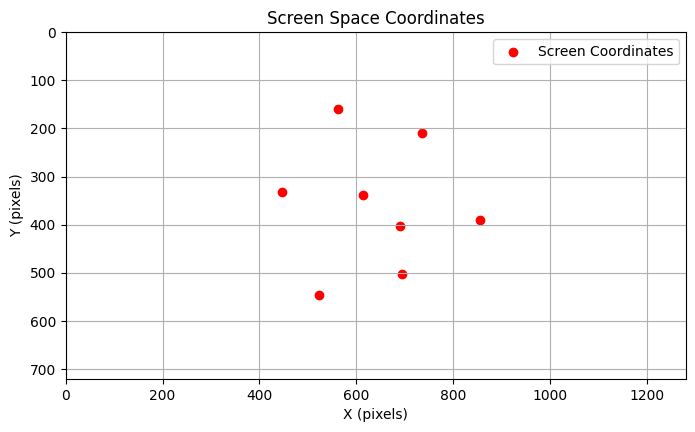

In [ ]:
import matplotlib.pyplot as plt

# 繪製屏幕空間的 2D 座標
def plot_screen_coords(screen_coords, width, height):
    plt.figure(figsize=(8, 4.5))
    plt.scatter(screen_coords[:, 0], screen_coords[:, 1], color='red', label='Screen Coordinates')
    plt.xlim(0, width)
    plt.ylim(height, 0)  # 螢幕的 Y 軸是向下的
    plt.title("Screen Space Coordinates")
    plt.xlabel("X (pixels)")
    plt.ylabel("Y (pixels)")
    plt.grid(True)
    plt.legend()
    plt.show()

# 繪製
plot_screen_coords(screen_coords, 1280, 720)

---
# Load inputs

## OBJ & PLY

In [4]:
class Mesh:
    def __init__(self):
        self.vertices = np.array([[]])
        self.faces = np.array([[]])
        self.colors = np.array([[]])  # Optional: To store vertex colors

        #calculated results
        self.clip_space_vertices = np.array([[]])
        self.NDC_vertices = np.array([[]])
        self.screen_space_vertices = np.array([[]])

    def load_obj(self, filepath):
        """
        Load a .obj file and extract vertex positions.
        filepath: Path to the .obj file
        Returns: Nx3 numpy array of vertex positions
        """
        vertices = []
        faces = []
        with open(filepath, 'r') as file:
            for line in file:
                if line.startswith('v '):  # Line defines a vertex
                    parts = line.strip().split()
                    if len(parts) >= 4:
                        vertices.append([float(parts[1]), float(parts[2]), float(parts[3])])
                elif line.startswith('f '):  # Line defines a face
                    parts = line.strip().split()
                    # OBJ indices are 1-based, so we subtract 1 for 0-based indexing
                    face = [int(part.split('/')[0]) - 1 for part in parts[1:4]]
                    faces.append(face)
        self.vertices = np.array(vertices)
        self.faces = np.array(faces)

    def load_ply(self, filepath):
        """
        Load a .ply file and extract vertex positions and face indices.
        Assumes the PLY file is in ASCII format with properties: x, y, z, red, green, blue
        and faces defined as a list of vertex indices.

        filepath: Path to the .ply file
        """
        with open(filepath, 'r') as file:
            line = file.readline().strip()
            if line != 'ply':
                raise ValueError("The file does not start with 'ply' header.")

            # Initialize variables
            num_vertices = 0
            num_faces = 0
            header_ended = False
            properties = []

            # Parse header
            while not header_ended:
                line = file.readline().strip()
                if line.startswith('element vertex'):
                    num_vertices = int(line.split()[-1])
                elif line.startswith('element face'):
                    num_faces = int(line.split()[-1])
                elif line.startswith('property'):
                    properties.append(line)
                elif line == 'end_header':
                    header_ended = True

            # Determine property indices (optional: if you want to store colors)
            property_names = [prop.split()[-1] for prop in properties]
            try:
                x_idx = property_names.index('x')
                y_idx = property_names.index('y')
                z_idx = property_names.index('z')
            except ValueError:
                raise ValueError("PLY file does not contain x, y, z properties.")

            # Optional: Check for color properties
            has_color = all(color in property_names for color in ['red', 'green', 'blue'])
            if has_color:
                red_idx = property_names.index('red')
                green_idx = property_names.index('green')
                blue_idx = property_names.index('blue')

            # Read vertex data
            vertices = []
            colors = []
            for _ in range(num_vertices):
                parts = file.readline().strip().split()
                if len(parts) < 3:
                    raise ValueError("Vertex line does not have enough coordinates.")
                vertex = [float(parts[x_idx]), float(parts[y_idx]), float(parts[z_idx])]
                vertices.append(vertex)
                if has_color:
                    color = [int(parts[red_idx]), int(parts[green_idx]), int(parts[blue_idx])]
                    colors.append(color)

            self.vertices = np.array(vertices)
            if has_color:
                self.colors = np.array(colors)
            else:
                self.colors = None  # Or handle as needed

            # Read face data
            faces = []
            for _ in range(num_faces):
                parts = file.readline().strip().split()
                if len(parts) < 4:
                    raise ValueError("Face line does not have enough indices.")
                vertex_count = int(parts[0])
                if vertex_count != 3:
                    raise ValueError("Only triangular faces are supported.")
                # PLY indices are 0-based
                face = [int(idx) for idx in parts[1:4]]
                faces.append(face)

            self.faces = np.array(faces)

### Test

In [5]:
mesh = Mesh()
mesh.load_ply( '../mesh/box.ply' )

## Camera

**Arguments**  
1. Camera postions
  - `eye`: The position of the camara.
  - `center`: The center of the screen space.  
    - Camera facing direction: (`eye` - `center`)
  - `up`: The Up direction of the camera.  
2. Screen
  - `screen_W`: The width of the screen.
  - `screen_H`: The height of the screen.
    - aspect_ratio: `screen_W` / `screen_H`
  - `screen_buffer`: The array with W*H pixels, each presented with RGB.
3. Projection parameters
  - `near_clipping_plane`: The near clipping plane.
  - `far_clipping_plane`: The far clipping plane.
  - `fov`: The vertival field of view in degrees.(FOVy)

In [6]:
class Camera:
    def __init__(self, eyeX: float,   eyeY: float,   eyeZ: float,
              centerX: float,  centerY: float, centerZ: float,
              upX: float,    upY: float,   upZ: float,
              screen_W: int, screen_H: int,
              near_clipping_plane: float, far_clipping_plane: float,
              fov: float):
        self.eyeX = eyeX
        self.eyeY = eyeY
        self.eyeZ = eyeZ
        self.eye = np.array([eyeX, eyeY, eyeZ])
        self.centerX = centerX
        self.centerY = centerY
        self.centerZ = centerZ
        self.center = np.array([centerX, centerY, centerZ])
        self.upX = upX
        self.upY = upY
        self.upZ = upZ
        self.up = np.array([upX, upY, upZ])

        self.screen_W = screen_W
        self.screen_H = screen_H
        self.aspect_ratio = screen_W / screen_H
        self.screen_buffer = np.zeros((screen_H, screen_W, 3), dtype=np.uint8)
        self.screen_buffer.fill(255)
        self.screen_depth_buffer = np.zeros((screen_H, screen_W))
        self.screen_depth_buffer.fill(1.1)

        self.near_clipping_plane = near_clipping_plane
        self.far_clipping_plane = far_clipping_plane
        self.fov = fov
    def set_eye(self, eyeX: float, eyeY: float, eyeZ: float):
        self.eyeX = eyeX
        self.eyeY = eyeY
        self.eyeZ = eyeZ
        self.eye = np.array([eyeX, eyeY, eyeZ])
    def draw_screen(self):
        plt.imshow(self.screen_buffer)
        plt.axis('off')
        plt.show()


In [7]:
camera = Camera( eyeX=4, eyeY=4, eyeZ=4,
          centerX=0, centerY=0, centerZ=0,
          upX=0, upY=1, upZ=0,
          screen_W=1280, screen_H=720,
          near_clipping_plane=0.1, far_clipping_plane=1000,
          fov=45 )

# Vertex Shading

Project vertexes onto clip space by performong the MVP transformation.  

**References**  
- [OpenGL中投影矩阵(Projection Matrix)详解 - CSDN](https://blog.csdn.net/qq_39300235/article/details/90670282)
- [OpenGL矩阵变换的数学推导 - 騰訊雲](https://cloud.tencent.com/developer/article/1389550)
- [Computing FOVX (openGL) - stackoverflow](https://stackoverflow.com/questions/5504635/computing-fovx-opengl)

## Model Matrix

_**SKIP FIRST**_  
We directly put the mesh in the center.

Local space -> Model space

In [8]:
def calc_Model_matrix( camera: Camera, mesh: Mesh):
  Model = np.eye(4)
  return Model

In [9]:
calc_Model_matrix(camera, mesh)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

## View Matrix

Model space -> View space

The coordinates of the camera is as follows:
- `z axis`: The camera facing direction. ( eye - center )
- `x axis`: The right direction of the camera. ( cross(z, u) )
- `y axis`: The up direction of the camera. ( cross(z, x) )

In [ ]:
def calc_View_matrix( camera: Camera):
    # Calculate the Z axis
    Z = camera.eye - camera.centerZ
    Z = Z / np.linalg.norm(Z)

    # Calculate the X axis
    X = np.cross(camera.up, Z)
    X = X / np.linalg.norm(X)

    # Calculate the Y axis
    Y = np.cross(Z, X)
    Y = Y / np.linalg.norm(Y)

    View = [ [ X[0], Y[0], Z[0], -np.dot(X, camera.eye)],
             [ X[1], Y[1], Z[1], -np.dot(Y, camera.eye)],
             [ X[2], Y[2], Z[2], -np.dot(Z, camera.eye)],
             [ 0.00, 0.00, 0.00,          1.00         ] ]
    View = np.array(View)
    return View

In [12]:
calc_View_matrix(camera)

array([[ 0.70710678, -0.40824829,  0.57735027, -0.        ],
       [ 0.        ,  0.81649658,  0.57735027, -0.        ],
       [-0.70710678, -0.40824829,  0.57735027, -6.92820323],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

## Projection Matrix

View Space -> Clip Space

Perspective projection.
1. We need to translate FOVy from degree to radius.
2. Calculate fy and fx.
3. Derive the projection matrix.

In [13]:
def calc_Projection_matrix( camera: Camera):

  fy = 1.0 / np.tan( np.radians( camera.fov ) / 2 )
  fx = fy / camera.aspect_ratio

  far = camera.far_clipping_plane
  near = camera.near_clipping_plane
  Projection = [ [ fx,  0,       0       ,       0        ],
          [ 0,  fy,       0       ,       0        ],
          [ 0,  0, - (far+near) / (far-near), (-2*far*near) / (far-near) ],
          [ 0,  0,       -1       ,       0        ] ]

  Projection = np.array(Projection)
  return Projection

In [14]:
calc_Projection_matrix(camera)

array([[ 1.35799513,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  2.41421356,  0.        ,  0.        ],
       [ 0.        ,  0.        , -1.00020002, -0.20002   ],
       [ 0.        ,  0.        , -1.        ,  0.        ]])

## Perform MVP Transformation

1. Expand the vertices into homogeneous matrix
2. Then multiply the matrixes

In [ ]:
def perform_MVP_transformation( camera: Camera, mesh: Mesh):
  M = calc_Model_matrix(camera, mesh)
  V = calc_View_matrix(camera)
  P = calc_Projection_matrix(camera)
  MVP = P @ V @ M
  vertices_homogeneous = np.hstack((mesh.vertices, np.ones((mesh.vertices.shape[0], 1))))
  mesh.clip_space_vertices = vertices_homogeneous @ MVP.T
  return mesh

In [ ]:
mesh = perform_MVP_transformation(camera, mesh)

## NDC Transformation

Normalized Device Coordinate Transformation.  

Original vertices: [ Xc, Yc, Zc, Wc ]  
NDC vertices: [ Xc/Wc, Yc/Wc, Zc/Wc ]

In [ ]:
def NDC_transformation(mesh):
  ndc_space_vertices = []

  for vertex in mesh.clip_space_vertices:
      x_c, y_c, z_c, w_c = vertex

      x_ndc = x_c / w_c
      y_ndc = y_c / w_c
      z_ndc = z_c / w_c

      ndc_space_vertices.append([x_ndc, y_ndc, z_ndc])

  mesh.NDC_vertices = np.array(ndc_space_vertices)
  return mesh

In [ ]:
mesh = NDC_transformation(mesh)

## NDC to Screen

**Note that the Y coordinate should be flipped**

- Upper left corner: (0,0)  
- Lower right corener: (width, height)  

In [ ]:
def NDC_to_screen(camera: Camera, mesh: Mesh):
  ndc_x = mesh.NDC_vertices[:, 0]
  ndc_y = mesh.NDC_vertices[:, 1]

  screen_x = (ndc_x + 1) / 2 * camera.screen_W
  screen_y = (1 - (ndc_y + 1) / 2) * camera.screen_H

  mesh.screen_space_vertices = np.column_stack((screen_x, screen_y))
  return mesh

In [ ]:
mesh = NDC_to_screen(camera, mesh)

## Test the function

Output the function into GIF and see if it works well.

- `plot_screen_coords(screen_coords, width, height):`



## Picture

In [ ]:
import matplotlib.pyplot as plt

def plot_screen_coords(screen_coords, width, height):
    """
    Plots screen coordinates on a screen-sized canvas and returns the figure.

    Parameters:
    screen_coords (numpy array): Array of screen coordinates, shape (N, 2).
    width (int): Screen width in pixels.
    height (int): Screen height in pixels.

    Returns:
    matplotlib.figure.Figure: The figure object for further processing.
    """
    # Create a figure with a fixed aspect ratio to match screen dimensions
    fig, ax = plt.subplots(figsize=(width / 100, height / 100))  # Scaling by 100 for proportionality
    ax.scatter(screen_coords[:, 0], screen_coords[:, 1], color='red', label='Screen Coordinates')

    # Set screen limits
    ax.set_xlim(0, width)
    ax.set_ylim(height, 0)  # Invert Y-axis since screen Y-axis goes downward

    # Titles and labels
    ax.set_title("Screen Space Coordinates")
    ax.set_xlabel("X (pixels)")
    ax.set_ylabel("Y (pixels)")

    # Add grid and legend
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

    return fig  # Return the figure object

Camera position: (3, 3, 3)


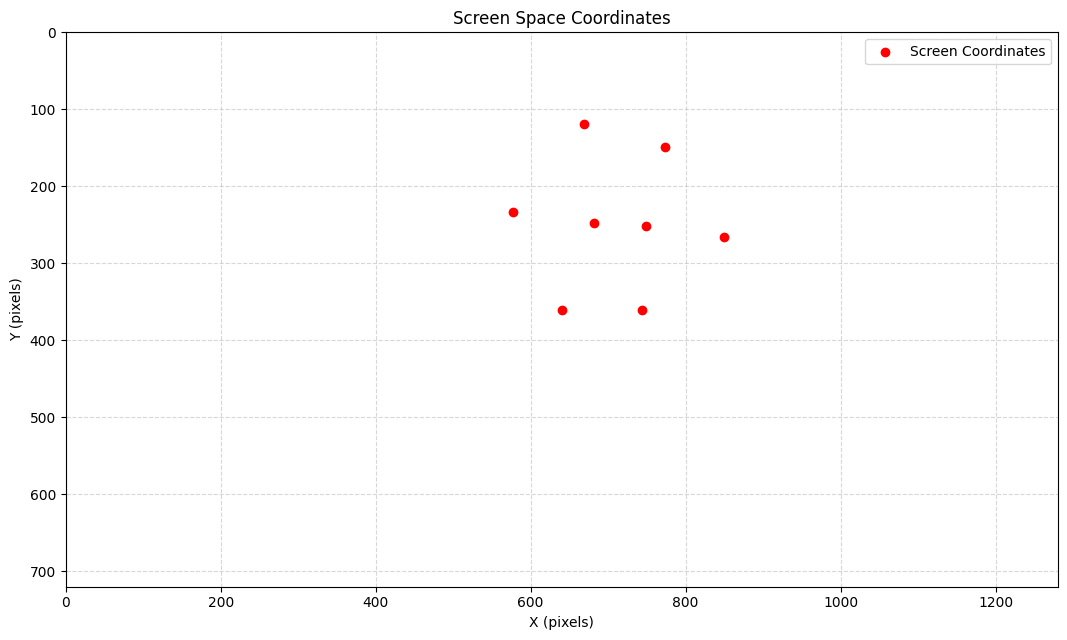

In [ ]:
box = Mesh()
# box.load_obj('/content/drive/MyDrive/ICLAB_mesh/box.obj')
box.load_ply( '/content/drive/MyDrive/ICLAB_mesh/colored_box.ply' )
teapot = Mesh()
teapot.load_obj('/content/drive/MyDrive/ICLAB_mesh/teapot.obj')
camera = Camera(
    eyeX=0, eyeY=2, eyeZ=0,
    centerX=0, centerY=0, centerZ=0,
    upX=0, upY=1, upZ=0,
    screen_W=1280, screen_H=720,
    near_clipping_plane=0.1, far_clipping_plane=1000,
    fov=45
)

for i in range(1):
  camera.set_eye(3, 3, 3);
  print(f"Camera position: ({camera.eyeX}, {camera.eyeY}, {camera.eyeZ})")
  perform_MVP_transformation(camera, box)
  NDC_transformation(box)
  NDC_to_screen(camera, box)
  fig = plot_screen_coords(box.screen_space_vertices, camera.screen_W, camera.screen_H)

In [ ]:
box.screen_space_vertices

array([[640.        , 360.        ],
       [744.10493932, 360.        ],
       [681.15387013, 247.56553587],
       [576.68984435, 233.3796887 ],
       [748.63961031, 251.36038969],
       [849.60615755, 265.78418216],
       [772.80553635, 148.7369004 ],
       [669.23570913, 119.0205544 ]])

In [ ]:
box.vertices

array([[0., 0., 0.],
       [1., 0., 0.],
       [1., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 1.],
       [1., 1., 1.],
       [0., 1., 1.]])

## Annimation

In [ ]:
import math
from tqdm import tqdm
import imageio
import numpy as np
import matplotlib.pyplot as plt

# Assuming the required classes and methods (Mesh, Camera, etc.) are defined elsewhere
mesh = Mesh()
mesh.load_obj('/content/drive/MyDrive/ICLAB_mesh/teapot.obj')

frames = []

# Initialize tqdm with dynamic postfix updates
with tqdm(total=(2 * 3 * 360) // (2 * 3), desc="Rendering frames", postfix={"Camera position": "(0, 0, 0)"}) as pbar:
    for rad in range(0, 2 * 3 * 360, 2 * 3):
        distance = 5
        rad /= 360
        CamX = distance * math.cos(rad)
        CamY = distance
        CamZ = distance * math.sin(rad)

        # Update the progress bar's postfix with the current camera position
        pbar.set_postfix({"Camera position": f"({CamX:.2f}, {CamY:.2f}, {CamZ:.2f})"})

        camera = Camera(
            eyeX=CamX, eyeY=CamY, eyeZ=CamZ,
            centerX=0, centerY=0, centerZ=0,
            upX=0, upY=1, upZ=0,
            screen_W=1280, screen_H=720,
            near_clipping_plane=0.1, far_clipping_plane=1000,
            fov=45
        )
        mesh = perform_MVP_transformation(camera, mesh)
        mesh = NDC_transformation(mesh)
        mesh = NDC_to_screen(camera, mesh)

        fig = plot_screen_coords(mesh.screen_space_vertices, camera.screen_W, camera.screen_H)

        # Save the figure as an image in memory
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)

        plt.close(fig)  # Close the figure to free memory

        # Update the progress bar
        pbar.update(1)

# Save all frames into a .gif
output_path = "/content/drive/MyDrive/ICLAB_mesh/teapot.gif"
imageio.mimsave(output_path, frames, fps=24)

print(f"GIF saved to {output_path}")

Rendering frames:   0%|          | 0/360 [00:00<?, ?it/s, Camera position=(5.00, 5.00, 0.00)]<ipython-input-29-ebc55f725455>:41: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
Rendering frames:  14%|█▍        | 50/360 [00:22<02:20,  2.21it/s, Camera position=(3.36, 5.00, 3.70)]


KeyboardInterrupt: 

<Figure size 1280x720 with 0 Axes>

# Rasterization

## Anti-aliasing edges


### NOT IMPLEMENTED
Solve the problem by _**Wu, Xiao-Lin's algorithm**_.
- [YT explanation](https://www.youtube.com/watch?v=YAsKbVYS6jY)
- [Example](https://code.gamelet.com/edit/Line_Renderer)

In [ ]:
# def anti_aliasing_line( screen: np.array, start: int, end: int ):
#   start_X = start[0]
#   start_Y = start[1]
#   end_X = end[0]
#   end_Y = end[1]

#   steep = ( math.abs(end_Y - start_Y) > math.abs(end_X - start_X) )

#   # first transform the lines
#   #swap x, y
#   if steep:
#     start_X, start_Y = start_Y, start_X
#     end_X, end_Y = end_Y, end_X
#   # swap start and end
#   if start[0] > end[0]:
#     start_X, end_X = end_X, start_X
#     start_Y, end_Y = end_Y, start_Y

#   # Calculate dx and dy
#   dx = end_X - start_X
#   dy = end_Y - start_Y

#   if dx == 0:
#     gradient = 1
#   else:
#     gradient = dy/dx

#   if (dx == 0):
#     gradient = 1
#   else:
#     gradient = dy/dx

#   # draw starting point
#   color = (255, 255, 255)

#   start_X_int = ( start_X + 0.5 ) // 2
#   start_Y = start_Y + gradient * ( start_X_int - start_X )
#   start_X_gap = start_X + 0.5 - int(start_X)
#   start_Y_int = int(start_Y)

#   if steep:
#     screen[start_Y_int, int(start_X_int)] = color
#   else:
#     screen[int(start_X_int), int(start_Y)] = color


## Determine if the point is in triangle
```
    ( x1, y1 )
       /\
      /  \
     /    \
    -- -- -- --  
( x2, y2 )   ( x3, y3 )
```

Two ways:
1. By Area
2. By Cross product

### Vector Cross Product Method (Half-Plane Technique)

**Concept:**  
This method uses the sign of the cross product to determine if the point lies on the same side of all the triangle's edges.

**Steps:**

1. **Define the Triangle and Point:**
   - Triangle vertices \( A(x_A, y_A) \), \( B(x_B, y_B) \), \( C(x_C, y_C) \).
   - Point \( P(x, y) \).

2. **Compute Vectors:**
   - Compute vectors for the edges \( AB \), \( BC \), and \( CA \).
   - Compute vectors from the triangle's vertices to point \( P \).

3. **Calculate Cross Products:**
   \begin{align*}
   \text{Cross}_1 &= (B_x - A_x)(P_y - A_y) - (B_y - A_y)(P_x - A_x) \\
   \text{Cross}_2 &= (C_x - B_x)(P_y - B_y) - (C_y - B_y)(P_x - B_x) \\
   \text{Cross}_3 &= (A_x - C_x)(P_y - C_y) - (A_y - C_y)(P_x - C_x)
   \end{align*}

4. **Check the Signs:**
   - If all cross products have the same sign (all positive or all negative), then \( P \) is inside the triangle.
   - If the signs differ, \( P \) is outside the triangle.


#### By area

In [ ]:
def PointInTriangle2D(position1, position2, position3,x,y):

    x1 = position1[0]
    x2 = position2[0]
    x3 = position3[0]

    y1 = position1[1]
    y2 = position2[1]
    y3 = position3[1]

    A1 = 0.5 * abs((x * (y2-y3)) + (x2 * (y3-y)) + (x3 * (y-y2)))
    A2 = 0.5 * abs((x1 * (y-y3)) + (x * (y3-y1)) + (x3 * (y1-y)))
    A3 = 0.5 * abs((x1 * (y2-y)) + (x2 * (y-y1)) + (x * (y1-y2)))
    Atotal = 0.5 * abs((x1 * (y2-y3)) + (x2 * (y3-y1)) + (x3 * (y1-y2)))

    if(abs(Atotal - (A1+A2+A3))<=0.00000001):
        return 1
    else:
        return 0


#### By Cross Product

In [ ]:
def sign(p1, p2, p3):
    return (p1[0] - p3[0])*(p2[1] - p3[1]) - (p2[0] - p3[0])*(p1[1] - p3[1])

def is_point_in_triangle_cross_product(A, B, C, P):
    d1 = sign(P, A, B)
    d2 = sign(P, B, C)
    d3 = sign(P, C, A)

    has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0)
    has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0)

    return not (has_neg and has_pos)


#### Verification

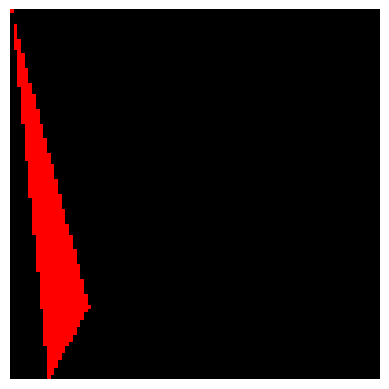

In [ ]:
P1 = [0, 0]
P2 = [21, 80]
P3 = [10,100]

screen_buffer = []
for h in range(100):
  tmp = []
  for w in range(100):
    if is_point_in_triangle_cross_product( P1, P2, P3, [w, h] ):
      tmp.append([255, 0, 0])
    else:
      tmp.append([0, 0, 0])
  screen_buffer.append(tmp)

plt.imshow(screen_buffer)
plt.axis('off')
plt.show()

In [ ]:
for i in range(1000):
  for j in range(1000):
    assert PointInTriangle2D([0,0],[21,80],[10,100],i,j) == is_point_in_triangle_cross_product([0,0],[21,80],[10,100],[i,j])

## Calculate Depth and color if it is in the triangle

We calculate them through interpolation (Barycentric coordinates). All values are stored in the vertexes.

reference: [https://hackmd.io/@leon890820/rkI-2oYXi](https://hackmd.io/@leon890820/rkI-2oYXi)

### Barycentric interpolation

- input
  - position1, value1
  - position2, value2
  - position3, value3
  - x, y
- output
  - value corresponding to (x, y)

In [ ]:
def Barycentric_interpolation( P1, value1, P2, value2, P3, value3, x, y):

  x1 = P1[0]
  x2 = P2[0]
  x3 = P3[0]

  y1 = P1[1]
  y2 = P2[1]
  y3 = P3[1]

  A1 = 0.5*abs((x*(y2-y3)) + (x2*(y3-y)) + (x3*(y-y2)))
  A2 = 0.5*abs((x1*(y-y3)) + (x*(y3-y1)) + (x3*(y1-y)))
  A3 = 0.5*abs((x1*(y2-y)) + (x2*(y-y1)) + (x*(y1-y2)))
  Atotal = 0.5*abs((x1*(y2-y3)) + (x2*(y3-y1)) + (x3*(y1-y2)))

  L1 = A1 / Atotal
  L2 = A2 / Atotal
  L3 = A3 / Atotal

  return L1*value1 + L2*value2 + L3*value3



In [ ]:
def GetDepth(position1,position2,position3,position1_depth,position2_depth,position3_depth,x,y):
  x1 = position1[0]
  x2 = position2[0]
  x3 = position3[0]

  y1 = position1[1]
  y2 = position2[1]
  y3 = position3[1]

  A1 = 0.5*abs((x*(y2-y3)) + (x2*(y3-y)) + (x3*(y-y2)))
  A2 = 0.5*abs((x1*(y-y3)) + (x*(y3-y1)) + (x3*(y1-y)))
  A3 = 0.5*abs((x1*(y2-y)) + (x2*(y-y1)) + (x*(y1-y2)))
  Atotal = 0.5*abs((x1*(y2-y3)) + (x2*(y3-y1)) + (x3*(y1-y2)))

  L1 = A1 / Atotal
  L2 = A2 / Atotal
  L3 = A3 / Atotal

  return L1*position1_depth + L2*position2_depth + L3*position3_depth



In [ ]:
def GetColor( position1, position2, position3, position1_color, position2_color, position3_color, x, y):
  x1 = position1[0]
  x2 = position2[0]
  x3 = position3[0]

  y1 = position1[1]
  y2 = position2[1]
  y3 = position3[1]

  A1 = 0.5*abs((x*(y2-y3)) + (x2*(y3-y)) + (x3*(y-y2)))
  A2 = 0.5*abs((x1*(y-y3)) + (x*(y3-y1)) + (x3*(y1-y)))
  A3 = 0.5*abs((x1*(y2-y)) + (x2*(y-y1)) + (x*(y1-y2)))
  Atotal = 0.5*abs((x1*(y2-y3)) + (x2*(y3-y1)) + (x3*(y1-y2)))

  L1 = A1 / Atotal
  L2 = A2 / Atotal
  L3 = A3 / Atotal

  #position1_color: np.array([R,G,B])
  return L1*position1_color + L2*position2_color + L3*position3_color


## Write them into screen buffer

In [ ]:
box.screen_space_vertices

array([[640.        , 360.        ],
       [641.79466464, 360.        ],
       [565.76892926, 283.96632125],
       [553.24496757, 273.23291686],
       [727.04468522, 272.94322384],
       [718.04273886, 283.74395918],
       [641.79466464, 207.7106051 ],
       [640.        , 186.17662351]])

In [ ]:
from PIL import Image
box = Mesh()
box.load_ply( '/content/drive/MyDrive/ICLAB_mesh/box.ply' )

frames = []
with tqdm(total=(2 * 3 * 360) // (2 * 3), desc="Rendering frames", postfix={"Camera position": "(0, 0, 0)"}) as pbar:
    for rad in range(0, 2 * 3 * 360, 2 * 3):
        distance = 5
        rad /= 360
        CamX = distance * math.cos(rad)
        CamY = distance
        CamZ = distance * math.sin(rad)
        camera = Camera( eyeX=CamX, eyeY=CamY, eyeZ=CamZ,
          centerX=0, centerY=0, centerZ=0,
          upX=0, upY=1, upZ=0,
          screen_W=1280, screen_H=720,
          near_clipping_plane=0.1, far_clipping_plane=1000,
          fov=45 )
        # print(f"Camera position: ({camera.eyeX}, {camera.eyeY}, {camera.eyeZ})")

        # Update the progress bar's postfix with the current camera position
        pbar.set_postfix({"Camera position": f"({CamX:.2f}, {CamY:.2f}, {CamZ:.2f})"})

        perform_MVP_transformation(camera, box)
        NDC_transformation(box)
        NDC_to_screen(camera, box)

        for face in box.faces:
          # print("Face vertices indices:", face)
          P1 = box.screen_space_vertices[face[0]]
          P2 = box.screen_space_vertices[face[1]]
          P3 = box.screen_space_vertices[face[2]]
          P1_depth = box.NDC_vertices[face[0]][2]
          P2_depth = box.NDC_vertices[face[1]][2]
          P3_depth = box.NDC_vertices[face[2]][2]

          P1_color = box.colors[face[0]]
          P2_color = box.colors[face[1]]
          P3_color = box.colors[face[2]]

          for w in range( int(min( P1[0], P2[0], P3[0] ) + 0.5), int(max( P1[0], P2[0], P3[0] ) + 0.5) +1 ):
            for h in range( int(min( P1[1], P2[1], P3[1] ) + 0.5), int(max( P1[1], P2[1], P3[1] ) + 0.5) +1 ):
              if is_point_in_triangle_cross_product( P1, P2, P3, [w, h] ):
                # get depth
                depth = GetDepth( P1, P2, P3, P1_depth, P2_depth, P3_depth, w, h )
                if (depth < camera.screen_depth_buffer[h][w]):
                  camera.screen_depth_buffer[h][w] = depth
                  camera.screen_buffer[h][w] =  GetColor( P1, P2, P3, P1_color, P2_color, P3_color, w, h )
          # print("original vertices", box.vertices[face[0]], box.vertices[face[1]], box.vertices[face[2]])
          # print("screen space vertices",P1,P2,P3)

        frames.append(camera.screen_buffer)
        # Update the progress bar
        pbar.update(1)

# Convert arrays to PIL Image objects
images = [Image.fromarray(frame, mode='RGB') for frame in frames]

# Save as a GIF
images[0].save(
    "output.gif",
    save_all=True,
    append_images=images[1:],  # Add the rest of the frames
    duration=5,             # Duration of each frame in milliseconds
    loop=0                    # 0 means infinite loop
)


Rendering frames:   0%|          | 0/360 [00:00<?, ?it/s, Camera position=(5.00, 5.00, 0.00)]<ipython-input-39-7f6d536e0ff3>:17: RuntimeWarning: invalid value encountered in scalar divide
  L1 = A1 / Atotal
<ipython-input-39-7f6d536e0ff3>:18: RuntimeWarning: invalid value encountered in scalar divide
  L2 = A2 / Atotal
<ipython-input-39-7f6d536e0ff3>:19: RuntimeWarning: invalid value encountered in scalar divide
  L3 = A3 / Atotal
<ipython-input-39-7f6d536e0ff3>:17: RuntimeWarning: divide by zero encountered in scalar divide
  L1 = A1 / Atotal
<ipython-input-39-7f6d536e0ff3>:18: RuntimeWarning: divide by zero encountered in scalar divide
  L2 = A2 / Atotal
<ipython-input-39-7f6d536e0ff3>:19: RuntimeWarning: divide by zero encountered in scalar divide
  L3 = A3 / Atotal


[0 1 2]
[640. 360.] [640. 360.] [563.85661284 283.85661284]
Atotal:0.0, [640. 360.]
 [640. 360.]
 [563.85661284 283.85661284]
Atotal:0.0, [640. 360.]
 [640. 360.]
 [563.85661284 283.85661284]
Atotal:0.0, [640. 360.]
 [640. 360.]
 [563.85661284 283.85661284]
Atotal:0.0, [640. 360.]
 [640. 360.]
 [563.85661284 283.85661284]
Atotal:0.0, [640. 360.]
 [640. 360.]
 [563.85661284 283.85661284]
Atotal:0.0, [640. 360.]
 [640. 360.]
 [563.85661284 283.85661284]
Atotal:0.0, [640. 360.]
 [640. 360.]
 [563.85661284 283.85661284]
Atotal:0.0, [640. 360.]
 [640. 360.]
 [563.85661284 283.85661284]
Atotal:0.0, [640. 360.]
 [640. 360.]
 [563.85661284 283.85661284]
Atotal:0.0, [640. 360.]
 [640. 360.]
 [563.85661284 283.85661284]
Atotal:0.0, [640. 360.]
 [640. 360.]
 [563.85661284 283.85661284]
Atotal:0.0, [640. 360.]
 [640. 360.]
 [563.85661284 283.85661284]
Atotal:0.0, [640. 360.]
 [640. 360.]
 [563.85661284 283.85661284]
Atotal:0.0, [640. 360.]
 [640. 360.]
 [563.85661284 283.85661284]
Atotal:0.0, [640

Rendering frames:   0%|          | 1/360 [00:01<06:48,  1.14s/it, Camera position=(5.00, 5.00, 0.08)]

[0 1 2]
[640. 360.] [641.79466464 360.        ] [565.76892926 283.96632125]
[0 2 3]
[640. 360.] [565.76892926 283.96632125] [553.24496757 273.23291686]


KeyboardInterrupt: 

In [ ]:
# Save as a GIF
images[0].save(
    "output.gif",
    save_all=True,
    append_images=images[1:],  # Add the rest of the frames
    duration=10,             # Duration of each frame in milliseconds
    loop=0                    # 0 means infinite loop
)

In [ ]:
depth_map = []
MAX = max(camera.screen_depth_buffer.flatten())
MIN = min(camera.screen_depth_buffer.flatten())

for i in range(camera.screen_depth_buffer.shape[0]):
  tmp = []
  for j in range(camera.screen_depth_buffer.shape[1]):
    tmp.append([(camera.screen_depth_buffer[i][j] - MIN) / (MAX - MIN), 255, 255])
  depth_map.append(tmp)

plt.imshow(depth_map)
plt.axis('off')
plt.show()

In [ ]:
perform_MVP_transformation(camera, box).clip_space_vertices

In [ ]:
box.clip_space_vertices

## Webber implementation

In [ ]:
#   mesh  : screen position

#   mesh.screen_space_vertices
#   mesh.NDC_vertices[:, 2]  --> z

print(mesh.screen_space_vertices)

position_data = mesh.screen_space_vertices

print(mesh.NDC_vertices[:, 2])

z_vector = mesh.NDC_vertices[:, 2]

Depthstate = np.ones(1280 * 720, dtype=int)
Color   = np.zeros((2, 3))

for face in mesh.faces:
  print("Face vertices indices:", face)
  position1 = position_data[face[0]-1]
  position2 = position_data[face[1]-1]
  position3 = position_data[face[2]-1]
  print(position1,position2,position3)

  # 找出最大值的索引
  if position1[0] >= position2[0] and position1[0] >= position3[0]:
      max_index_x = 0
  elif position2[0] >= position1[0] and position2[0] >= position3[0]:
      max_index = 1
  elif position3[0] >= position1[0] and position3[0] >= position2[0]:
      max_index_x = 2
  else:
      max_index_x = 0

  # 找出最小值的索引
  if position3[0] <= position1[0] and position3[0] <= position2[0]:
      min_index_x = 2
  elif position2[0] <= position1[0] and position2[0] <= position3[0]:
      min_index_x = 1
  elif position1[0] <= position2[0] and position1[0] <= position3[0]:
      min_index_x = 0
  else:
      min_index_x = 0

  # 找出最大值的索引
  if position1[1] >= position2[1] and position1[1] >= position3[1]:
      max_index_y = 0
  elif position2[1] >= position1[1] and position2[1] >= position3[1]:
      max_index_y = 1
  elif position3[1] >= position1[1] and position3[1] >= position2[1]:
      max_index_y = 2
  else:
      max_index_y = 0

  # 找出最小值的索引
  if position3[1] <= position1[1] and position3[1] <= position2[1]:
      min_index_y = 2
  elif position2[1] <= position1[1] and position2[1] <= position3[1]:
      min_index_y = 1
  elif position1[1] <= position2[1] and position1[1] <= position3[1]:
      min_index_y = 0
  else:
      min_index_y = 0

  # start point = min_index_x , min_index_y
  # end point = max_index_x , max_index_y

  start_point = [position_data[face[min_index_x] - 1][0], position_data[face[min_index_y] - 1][1]]
  end_point = [position_data[face[max_index_x] - 1][0], position_data[face[max_index_y] - 1][1]]

  print(f"start_point:{start_point}")
  print(f"end_point:{end_point}")

  for y in range(int(start_point[1]),int(end_point[1])+2):
      for x in range(int(start_point[0]),int(end_point[0])+2):
        if(PointInTriangle2D(position1,position2,position3,x,y)!=0):
          depth = GetDepth(position1,position2,position3,z_vector[face[0]-1],z_vector[face[1]-1],z_vector[face[2]-1],x,y)
          #color = GetColor(position1,position2,position3,)  # need to fill parameter, each vertices corresponding color, reference GetDepth
          if( depth < Depthstate[x+1280*y] ):        #replace color
            Depthstate[x+1280*y] = depth
            #Color[x+1280*y] = color
            #print(x,y,depth)





[[194.07586493 175.50708654]
 [192.97638945 185.20977561]
 [197.84988097 166.01608027]
 ...
 [750.71003554 217.34998958]
 [750.71003554 217.34998958]
 [751.21928752 217.62755375]]
[0.96684068 0.96710585 0.96663498 ... 0.98145889 0.98145889 0.98146174]
Face vertices indices: [2908 2920 2938]
[644.75170395 160.21350701] [699.29094516 396.55935702] [701.17726608 146.2537589 ]
start_point:[644.7517039527247, 146.25375889833003]
end_point:[701.1772660848156, 396.55935701990364]
Face vertices indices: [2938 2930 2908]
[701.17726608 146.2537589 ] [634.96124949 177.51831931] [644.75170395 160.21350701]
start_point:[634.961249491737, 146.25375889833003]
end_point:[701.1772660848156, 177.51831931154302]
Face vertices indices: [2868 2876 2920]
[717.3347167  388.13379599] [640.2047037  160.09707995] [699.29094516 396.55935702]
start_point:[640.2047036953873, 160.09707995052756]
end_point:[717.3347167048081, 396.55935701990364]
Face vertices indices: [2920 2908 2868]
[699.29094516 396.55935702] [64

KeyboardInterrupt: 